
在上节 https://www.joinquant.com/post/12940 中，我们简单介绍了统计套利策略的原理，在本节中，我们将在沪深300各个行业中寻找可以配对的股票，并以此构造投资组合。投资组合更新的频率为每季度，我们主要步骤如下：

**1.划分行业：**在本研究中，我们主要研究的是银行，券商，医药，钢铁，煤炭，保险，房地产，家电，汽车制造这几个行业，概含了沪深300指数主要的行业

**2.收益率相关性：**我们选取的相关性阙值为0.7，太高导致价差波动小，太低则均值回归力度较弱。我们筛选出上一季度日收益率相关系数大于0.7的股票对作为备选股票

**3.平稳性分析：**在满足收益率相关系数大于0.7后，我们计算出价差，同时要求价差在0.05水平下通过单位根检验，这是为了防止上节中价差呈现单边走势的情况，我们要求价差必须围绕0轴波动

**4.价差形态过滤：**我们希望价差回归均值的速度较快，但由于我们调仓频率为一个季度，时间足够长，因此不需要通过这一步检验

![tt81.png][1]

通过以上我们获得所有满足条件的股票对，并按照上一节的股票对交易策略进行交易，即当价差大于1.5时做多以单位A，同时做空$\beta$单位的B，当价差小于1.5时相反，当价差归零时清仓。我们测试了2007年至2017年的收益情况。结果如下：

![31.png][2]

**可以发现我们获得一个很好的收益曲线！夏普值高达6.95！**

我们知道金融类股票的波动较小，因此我们剔除了银行，保险和券商股票，再构造投资组合，表现如下：
![32.png][3]

**累计收益率显著提高，回撤控制在较小范围！**

### 改进策略思考
我们知道有左侧交易和右侧交易，左侧偏向反转，右侧偏向趋势，我们考虑建立配对交易策略的右侧交易策略，即当价差从上往下穿过1.5阙值线时建仓，同时，当价差趋向0时，回归均值的力度已经转弱，我们考虑价差小于0.5时清仓。具体流程如下：

![6768.png][4]

最后的最后，我们集中比较一下两种策略以及分行业的股票套利策略表现：
![33.png][5]
![34.png][6]

以下是近十年两种策略分行业的年度收益情况：
![35.png][7]
![36.png][8]

### 反思：
在这两节中，我们构造了统计套利之股票配对交易策略，并进行了沪深300行业的回测。我们假设所有的沪深300均可融资融券，从表现看我们的策略获得一个较为满意的收益，有效对冲了大盘下跌的风险。然而现实中并不是每只股票均可融资融券，因此这里可能存在未被市场参与者未能获取的超额收益。下一步，我们可以尝试针对可以融资融券的股票进行统计套利的回测！

  [1]: https://image.joinquant.com/84b65f3206c5124ce326c95b56fcad8f
  [2]: https://image.joinquant.com/0b7d35614ec41e4098df94e5b88f12d7
  [3]: https://image.joinquant.com/2b1813ee7932b6082610a2c798b94ca6
  [4]: https://image.joinquant.com/1a01273483b080257636ac058361e3e0
  [5]: https://image.joinquant.com/7476d00db57ba6e366a2e2b876cfeaa0
  [6]: https://image.joinquant.com/a207a5ecf6a665596ebd7b9bca163654
  [7]: https://image.joinquant.com/a57254ee23063a6c7b7f74e4d56a0ac4
  [8]: https://image.joinquant.com/df2adef0a31d9cacdc6aa983855d3ec6

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

In [2]:
##价差函数
def get_jiacha(securityy, securityx,start_date,end_date):
    pricex=get_price(securityx,start_date,end_date,fields='close',fq='pre')['close']
    pricey=get_price(securityy,start_date,end_date,fields='close',fq='pre')['close']
    model = sm.OLS(log(pricey),log(pricex)).fit()
    slope=model.params[0]
    st1=log(pricey)-slope*log(pricex)
    st=(st1-mean(st1))/std(st1)
    return st,slope

In [3]:
def get_peidui(code_index,stocks,start_date,end_date,corrindex=0.7,stationindex=0.05): 
    ### 获得配对股票 ###
    ##输入：行业或者概念的代码，总的股票池，开始时间，结束时间，相关系数阙值，平稳性阙值
    ##输出：所有的配对股票，按照行业分类
    hangye=[]    
    for i in arange(len(code_index)):
        tempt99=[i99 for i99 in get_concept_stocks(code_index[i]) if i99 in stocks]
        hangye.append(tempt99)
    store=[]
    allstore=[]##储存所有配对股票    
    for i56 in arange(len(hangye)):
        price=get_price(hangye[i56],start_date,end_date,fields='close')['close']
        ##相关系数阙值

        for i in arange(len(price.columns)-1):
            for j in arange(i+1,len(price.columns)):
                if corrcoef(price[price.columns[i]],price[price.columns[j]])[0][1]>corrindex and \
                ts.adfuller(get_jiacha(price.columns[i],price.columns[j],start_date,end_date)[0],0)[1]<stationindex: ###平稳性检验以及相关性检验
                    store.append([price.columns[i],price.columns[j]])
        allstore=allstore+store
    return allstore

In [4]:
def get_cumrate(allstore,start_date,end_date,jiacha_index=1.5):
    ### 计算累计净值 ###
    ##输入：allstore所有的配对股票，开始时间，结束时间
    ##输出：每个配对股票的净值
    bigstore=pd.DataFrame()
    if len(allstore)<1:
        bigstore['0']=[1 for i in arange(len(get_price('600001.XSHG',start_date,end_date))-2)]
    else:
        for j in arange(len(allstore)):##allstore长度
            price=get_price(allstore[j],start_date,end_date,fields='close',fq='pre')['close']
            st,slope=get_jiacha(allstore[j][0],allstore[j][1],start_date,end_date)
            u=0
            sec1=[] 
            sec2=[]
            sec1num=0
            sec2num=0
            for i in arange(1,len(st)):
                if u==0 and st[i]>jiacha_index and st[i]<3:
                    sec1num=-1##做空sec1
                    sec2num=-sec1num*slope ##做多sec2
                    u=i
                elif (u<>0 and st[i]*st[i-1]<0) or (abs(st[i])>3): ##此时价差变0清仓,或者价差偏离过大达到3清仓
                    sec1num=0
                    sec2num=0
                    u=0
                elif u==0 and st[i]<-jiacha_index and st[i]>-3:
                    sec1num=1
                    sec2num=-sec1num*slope
                    u=i
                sec1.append(sec1num)
                sec2.append(sec2num) #储存的是建仓信号，长度为price-1

            sec1rate=price[allstore[j][0]].diff(1)[1:]/list(price[allstore[j][0]][:-1])
            sec2rate=price[allstore[j][1]].diff(1)[1:]/list(price[allstore[j][1]][:-1])

            sumrate=sec1rate[1:]*sec1[:-1]+sec2rate[1:]*sec2[:-1] #发出信号后一天建仓
            cumrate=[]
            tempt=1
            for i in arange(len(sumrate)):
                tempt=tempt*(1+sumrate[i])
                if sumrate[i-1]<>0:
                    tempt=tempt*(1-0.01/255)##融券费用
                if i >=1:
                    if sumrate[i-1]<>0 and sumrate[i]==0:
                        tempt=tempt*(1-0.001-0.00025) ##平仓手续费   
                cumrate.append(tempt)
            #plt.plot(cumrate)
            #plt.title('配对策略净值变化曲线')
            bigstore[j]=cumrate

    return bigstore

In [5]:
def trade(code_index,stocks,time,plot_index=True,print_index=True):
    ###交易函数 ###
    ##输入：行业代码，股票池，时间
    ##输出：净值曲线，总收益，年化收益，夏普比，最大回撤
    netvalue=[]##储存净值
    tempt22=1
    nianhua=[]##储存年末净值
    for ii11 in arange(len(time)-2):
        allstore=get_peidui(code_index,stocks,start_date=time[ii11],end_date=time[ii11+1])##获得配对
        bigstore=get_cumrate(allstore,start_date=time[ii11+1],end_date=time[ii11+2])
        tempt23=[ii77*tempt22 for ii77 in list(bigstore.mean(axis=1))]
        netvalue=netvalue+tempt23
        tempt22=netvalue[-1]
        nianhua.append(netvalue[-1])
    ###绘制净值图像
    if plot_index==True:
        plt.figure(figsize=(20,6))
        plt.plot(netvalue)
        timestamp=[time[i*4][:4] for i in arange(len(time)/4)]
        plt.xticks(np.arange(0,len(netvalue),len(netvalue)/len(timestamp)),timestamp)
        plt.grid(True)
        plt.title('配对策略净值')
        plt.xlabel('年份')
        plt.ylabel('净值')
    ###计算最大回撤，平均年化收益率，夏普比
    tt1=[]
    tt2=[]
    for i in arange(len(netvalue)):
        for j in arange(i+1,len(netvalue)):
            tt1.append((netvalue[i]-netvalue[j])/netvalue[i])
        tt2.append(max(tt1))
    huiche=max(tt2)*100 #最大回撤
    yearrate=[nianhua[i]/nianhua[i-1]-1 for i in arange(1,len(nianhua))]
    shouyi=[netvalue[ii88+1]/netvalue[ii88]-1 for ii88 in arange(len(netvalue)-1) ]#每日收益
    sharpe=(mean(shouyi)-0.0285/252)/std(shouyi)*np.sqrt(252)#夏普值
    #sharpe=(mean(yearrate)-0.04)/std(yearrate) 
    pjnh=((netvalue[-1])**(1./(len(time)/4))-1)*100 #平均年化
    ljnh=(netvalue[-1]-1)*100 #累计收益
    ##打印
    if print_index==True:
        print '-'*30
        print '%14s %15.5f' % ('累计收益%：',ljnh)
        print '%14s %15.5f' % ('平均年化%:',pjnh)
        print '%14s %15.5f' % ('夏普比：' , sharpe)
        print '%14s %15.5f' % ('最大回撤%:', huiche)

    ##返回一些数值进行对比:累计收益，平均年化，夏普值，最大回撤,年末净值
    return [ljnh,pjnh,sharpe,huiche,nianhua]

In [6]:
##获取沪深300分行业股票数据
##券商:GN780,银行：GN815，房地产GN733，保险GN646，汽车制造GN835，煤炭GN823，钢铁GN727，白酒GN705，家电GN706，化学制药GN750
stocks = get_index_stocks('000300.XSHG')
hangye=[]
code_index=['GN780','GN815','GN733','GN646','GN835','GN823','GN727','GN705','GN706','GN750']
for i in arange(len(code_index)):
    tempt99=[i99 for i99 in get_concept_stocks(code_index[i]) if i99 in stocks]
    hangye.append(tempt99)

In [7]:
###按照季度生成时间
time=[]
for i in arange(2007,2018):
    for j in arange(1,13,3):
        time.append(str(i)+'-'+str(j)+'-01')

------------------------------
累计收益%：     35989.54291
平均年化%:        70.80053
  夏普比：         6.71289
最大回撤%:         7.32311


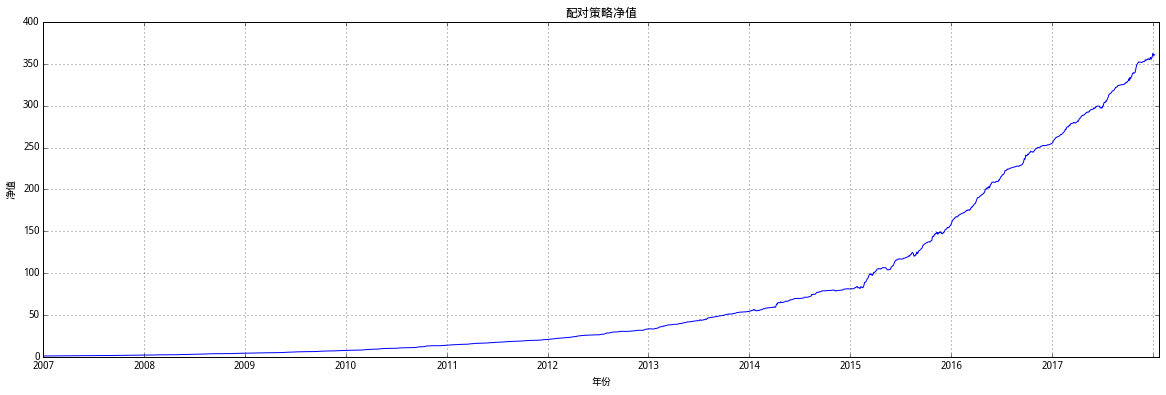

In [8]:
##储存输出指标
storeindex=pd.DataFrame()
##进行交易
storeindex['全部行业']=trade(code_index,stocks,time)

------------------------------
累计收益%：    182156.93730
平均年化%:        97.89090
  夏普比：         5.27588
最大回撤%:        13.94375


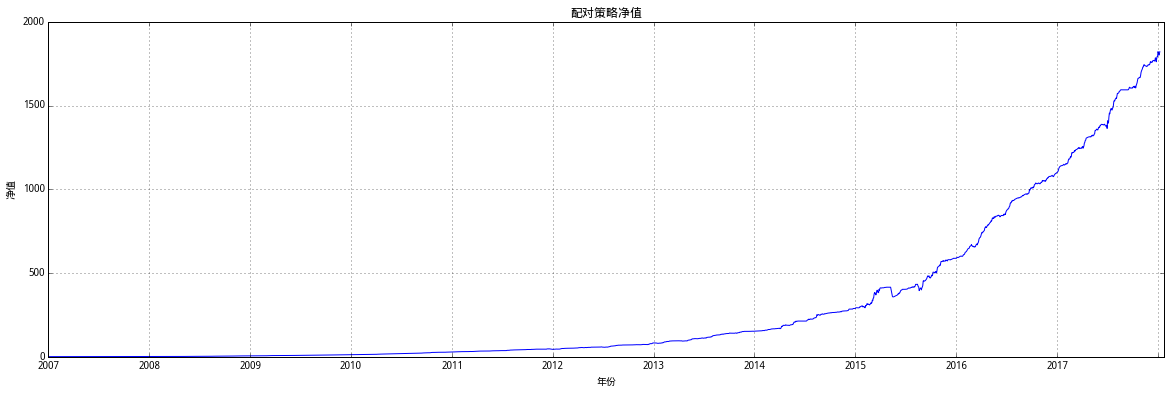

In [9]:
##根据经验我们知道银行，保险，券商等金融类股票波动较小，我们把他们剔除后看他们的配对交易收益
storeindex['非金融']=trade(['GN733','GN835','GN823','GN727','GN705','GN706','GN750'],stocks,time)

In [10]:
##分行业计算相关指标
storeindex['券商']=trade(['GN780'],stocks,time,print_index=False,plot_index=False)
storeindex['银行']=trade(['GN815'],stocks,time,print_index=False,plot_index=False)
storeindex['房地产']=trade(['GN733'],stocks,time,print_index=False,plot_index=False)
storeindex['保险']=trade(['GN646'],stocks,time,print_index=False,plot_index=False)
storeindex['汽车制造']=trade(['GN835'],stocks,time,print_index=False,plot_index=False)
storeindex['煤炭']=trade(['GN823'],stocks,time,print_index=False,plot_index=False)
storeindex['钢铁']=trade(['GN727'],stocks,time,print_index=False,plot_index=False)
storeindex['白酒']=trade(['GN705'],stocks,time,print_index=False,plot_index=False)
storeindex['家电']=trade(['GN706'],stocks,time,print_index=False,plot_index=False)
storeindex['化学制药']=trade(['GN750'],stocks,time,print_index=False,plot_index=False)

####  下面我们尝试改进一下策略，由于价差刚开始大于阙值时可能会会继续增大导致回撤，我们设置新的策略是当价差从大于3变成小于3时买入，同样当价差接近0时持有的价值已经较小，因此我们在价差从大于0.5变成小于0.5后卖出。这其实是把左侧交易变成右侧交易。

In [11]:
def get_cumrate2(allstore,start_date,end_date,jiacha_index=1.5):
    ### 计算累计净值 ###
    ##输入：allstore所有的配对股票，开始时间，结束时间
    ##输出：每个配对股票的净值
    bigstore=pd.DataFrame()
    if len(allstore)<1:
        bigstore['0']=[1 for i in arange(len(get_price('600001.XSHG',start_date,end_date))-2)]
    else:
        for j in arange(len(allstore)):##allstore长度
            price=get_price(allstore[j],start_date,end_date,fields='close',fq='pre')['close']
            st,slope=get_jiacha(allstore[j][0],allstore[j][1],start_date,end_date)
            u=0
            sec1=[] 
            sec2=[]
            sec1num=0
            sec2num=0
            for i in arange(1,len(st)):
                if u==0 and st[i-1]>jiacha_index and st[i]<jiacha_index: ##从上往下穿过1.5时开仓
                    sec1num=-1##做空sec1
                    sec2num=-sec1num*slope ##做多sec2
                    u=i
                elif (u<>0 and abs(st[i-1])>0.5 and abs(st[i])<0.5) or (abs(st[i])>3): ##此时价差变0清仓,或者价差偏离过大达到3清仓
                    sec1num=0
                    sec2num=0
                    u=0
                elif u==0 and st[i-1]<-jiacha_index and st[i]>-jiacha_index: ##从下往上穿过1.5时开仓
                    sec1num=1
                    sec2num=-sec1num*slope
                    u=i
                sec1.append(sec1num)
                sec2.append(sec2num) #储存的是建仓信号，长度为price-1

            sec1rate=price[allstore[j][0]].diff(1)[1:]/list(price[allstore[j][0]][:-1])
            sec2rate=price[allstore[j][1]].diff(1)[1:]/list(price[allstore[j][1]][:-1])

            sumrate=sec1rate[1:]*sec1[:-1]+sec2rate[1:]*sec2[:-1] #发出信号后一天建仓
            cumrate=[]
            tempt=1
            for i in arange(len(sumrate)):
                tempt=tempt*(1+sumrate[i])
                if i >=1:
                    if sumrate[i-1]<>0:
                        tempt=tempt*(1-0.01/250)##融券费用
                        if sumrate[i]==0:
                            tempt=tempt*(1-0.001-0.00025)    ##交易费用
                cumrate.append(tempt)
            #plt.plot(cumrate)
            #plt.title('配对策略净值变化曲线')
            bigstore[j]=cumrate

    return bigstore

In [12]:
def trade2(code_index,stocks,time,plot_index=True,print_index=True):
    ###交易函数2 ###
    ##输入：行业代码，股票池，时间
    ##输出：净值曲线，总收益，年化收益，夏普比，最大回撤
    netvalue=[]##储存净值
    tempt22=1
    nianhua=[]##储存年末净值
    for ii11 in arange(len(time)-2):
        allstore=get_peidui(code_index,stocks,start_date=time[ii11],end_date=time[ii11+1])##获得配对
        bigstore=get_cumrate2(allstore,start_date=time[ii11+1],end_date=time[ii11+2])
        tempt23=[ii77*tempt22 for ii77 in list(bigstore.mean(axis=1))]
        netvalue=netvalue+tempt23
        tempt22=netvalue[-1]
        nianhua.append(netvalue[-1])
    ###绘制净值图像
    if plot_index==True:
        plt.figure(figsize=(20,6))
        plt.plot(netvalue)
        timestamp=[time[i*4][:4] for i in arange(len(time)/4)]
        plt.xticks(np.arange(0,len(netvalue),len(netvalue)/len(timestamp)),timestamp)
        plt.grid(True)
        plt.title('配对策略净值')
        plt.xlabel('年份')
        plt.ylabel('净值')
    ###计算最大回撤，平均年化收益率，夏普比
    tt1=[]
    tt2=[]
    for i in arange(len(netvalue)):
        for j in arange(i+1,len(netvalue)):
            tt1.append((netvalue[i]-netvalue[j])/netvalue[i])
        tt2.append(max(tt1))
    huiche=max(tt2)*100 #最大回撤
    yearrate=[nianhua[i]/nianhua[i-1]-1 for i in arange(1,len(nianhua))]
    shouyi=[netvalue[ii88+1]/netvalue[ii88]-1 for ii88 in arange(len(netvalue)-1) ]#每日收益
    sharpe=(mean(shouyi)-0.0285/252)/std(shouyi)*np.sqrt(250)#夏普值
    pjnh=((netvalue[-1])**(1./(len(time)/4))-1)*100 #平均年化
    ljnh=(netvalue[-1]-1)*100 #累计收益
    ##打印
    if print_index==True:
        print '-'*30
        print '%14s %15.5f' % ('累计收益%：',ljnh)
        print '%14s %15.5f' % ('平均年化%:',pjnh)
        print '%14s %15.5f' % ('夏普比：' , sharpe)
        print '%14s %15.5f' % ('最大回撤%:', huiche)
    
    ##返回一些数值进行对比:累计收益，平均年化，夏普值，最大回撤,年净值
    return [ljnh,pjnh,sharpe,huiche,nianhua]

In [13]:
##进行新的策略交易
storeindex['全部行业2']=trade2(code_index,stocks,time,print_index=False,plot_index=False)
storeindex['非金融2']=trade2(['GN733','GN835','GN823','GN727','GN705','GN706','GN750'],stocks,time,print_index=False,plot_index=False)
storeindex['券商2']=trade2(['GN780'],stocks,time,print_index=False,plot_index=False)
storeindex['银行2']=trade2(['GN815'],stocks,time,print_index=False,plot_index=False)
storeindex['房地产2']=trade2(['GN733'],stocks,time,print_index=False,plot_index=False)
storeindex['保险2']=trade2(['GN646'],stocks,time,print_index=False,plot_index=False)
storeindex['汽车制造2']=trade2(['GN835'],stocks,time,print_index=False,plot_index=False)
storeindex['煤炭2']=trade2(['GN823'],stocks,time,print_index=False,plot_index=False)
storeindex['钢铁2']=trade2(['GN727'],stocks,time,print_index=False,plot_index=False)
storeindex['白酒2']=trade2(['GN705'],stocks,time,print_index=False,plot_index=False)
storeindex['家电2']=trade2(['GN706'],stocks,time,print_index=False,plot_index=False)
storeindex['化学制药2']=trade2(['GN750'],stocks,time,print_index=False,plot_index=False)

In [21]:
storeindex1=storeindex

In [75]:
##更改行名，同时计算每年的收益
storeindex1.index=['累计收益%','平均年化%','夏普值','最大回撤%','年净值']
##计算每年收益
shinianrate=pd.DataFrame()
for ii67 in arange(len(storeindex1.columns)):    
    uiu=[(storeindex1.iloc[-1][ii67][-1-4*i]/storeindex1.iloc[-1][ii67][-1-4*(i+1)]-1)*100 for i in arange(10)] #2008-2018年化收益
    shinianrate[storeindex1.columns[ii67]]=uiu
shinianrate.index=[str(ii864) for ii864 in arange(2017,2007,-1)]

In [90]:
###比较一下改进的策略和未改进策略
##生成交错的index【0,12,1,13...】
tempt776=[]
for i776 in arange(12):
    tempt776=tempt776+[i776,i776+12]


,全部行业,全部行业2,非金融,非金融2,券商,券商2,银行,银行2,房地产,房地产2,保险,保险2,汽车制造,汽车制造2
累计收益%,35998.35,1384.286,182156.9,4254.532,8892.435,551.2593,7427.752,652.0736,390742.9,6598.767,285.4695,84.91772,681.8732,190.0615
平均年化%,70.80432,27.79139,97.8909,40.92715,50.53074,18.57077,48.11735,20.13237,112.1024,46.55463,13.05033,5.747662,20.55749,10.16523
夏普值,6.948543,4.285662,5.275877,3.694609,3.55296,2.046436,4.318732,2.604052,4.344805,3.153454,1.679565,0.7941336,1.283891,0.7274139
最大回撤%,7.316716,7.352691,13.94375,7.39032,9.705635,6.263141,6.634623,4.397962,23.9856,5.449768,6.365275,4.05662,20.04462,23.31803


In [94]:
storeindex1[:-1].iloc[:,tempt776[15:24]]

,煤炭2,钢铁,钢铁2,白酒,白酒2,家电,家电2,化学制药,化学制药2
累计收益%,229.1934,959.7964,246.9088,31.97737,22.69578,1192.554,270.3923,768.5929,241.2053
平均年化%,11.43998,23.9373,11.97227,2.554447,1.876829,26.19461,12.64101,21.71579,11.80365
夏普值,1.028282,1.579883,0.9849366,0.01799145,-0.1620536,1.635398,0.980297,1.451573,0.851804
最大回撤%,13.43132,11.37708,10.31461,9.372635,7.313153,11.24815,7.705736,10.39782,11.18275


In [74]:
###近十年各行业标准策略每年收益率情况
shinianrate.iloc[:,:11]

,全部行业,非金融,券商,银行,房地产,保险,汽车制造,煤炭,钢铁,白酒,家电
2017,43.374497,67.715375,31.157004,37.220780,68.051485,11.908842,23.832291,60.676597,42.554389,8.681982,16.828608
2016,73.045802,87.606505,73.237407,47.931498,92.702984,44.694205,24.390914,36.163588,56.680092,0.000000,42.157159
2015,87.413288,114.068589,118.418676,70.680948,182.131038,46.848888,8.490181,18.967875,68.813437,0.000000,99.501733
2014,54.252412,91.913083,28.972415,40.647905,100.088921,17.571398,0.000000,30.719199,2.870304,21.370870,27.710186
2013,68.430184,99.139680,81.430820,27.559198,98.463189,20.675230,19.176097,0.000000,22.277904,1.972493,12.245891
2012,62.124883,62.161048,85.660451,37.756974,72.977620,0.000000,31.602411,1.104353,0.000000,1.196550,0.000000
2011,68.659565,103.500942,49.248848,43.269864,115.175938,7.640108,47.879670,94.068395,0.000000,-1.331203,-1.518100
2010,71.673487,113.963463,19.938291,55.386869,112.454515,0.000000,93.859601,0.000000,0.000000,3.554363,47.479586
2009,115.378049,222.437618,57.715104,53.991063,295.856777,6.147531,0.000000,35.539289,0.000000,-0.939281,12.132745
2008,144.392647,167.743005,12.816298,156.434453,158.712859,0.000000,4.057777,0.000000,123.451360,0.000000,17.749064


In [77]:
###近十年各行业每年收益率情况
shinianrate.iloc[:,12:]

,全部行业2,非金融2,券商2,银行2,房地产2,保险2,汽车制造2,煤炭2,钢铁2,白酒2,家电2,化学制药2
2017,17.661884,23.905826,11.822599,17.815518,21.410206,3.243747,14.670505,27.431727,29.539496,3.621336,9.735337,7.260687
2016,28.600450,30.803648,28.854742,21.036569,29.881973,21.487227,12.185618,16.594178,22.043382,0.000000,27.373219,10.946659
2015,30.540985,67.069718,32.534949,22.530338,115.105612,19.314139,-4.563256,20.206350,25.066698,0.000000,25.406877,32.960174
2014,22.115226,36.572906,13.907628,13.764704,38.507335,7.362846,0.000000,16.206472,1.931526,13.195201,16.991853,33.832102
2013,27.160236,38.343260,29.947929,10.469978,35.199385,5.348916,15.109253,0.000000,6.628968,0.101328,6.849036,4.620188
2012,24.533728,28.262843,30.204530,15.162086,32.532226,0.000000,20.222533,-3.139345,0.000000,2.107065,0.000000,4.558272
2011,24.175462,39.728235,14.012163,17.432207,42.980811,3.091180,14.919079,41.554923,0.000000,4.580261,0.000000,23.510366
2010,27.819130,44.869561,6.190825,24.761966,44.366068,0.000000,39.591576,0.000000,0.000000,-0.182969,18.895572,-0.429716
2009,38.751864,66.120145,20.781580,23.787913,85.808635,5.970905,0.000000,10.404312,0.000000,3.954662,1.786801,5.865220
2008,67.945761,90.118024,7.448068,63.979145,82.226169,0.000000,6.423659,0.000000,61.426012,0.000000,13.423693,13.140676
